## Homework 3 - MNIST Classification 


# 2.1 Loading the MNIST dataset


In [2]:
# load packages
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

# load dataset
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised = True, with_info = True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# get some information about the dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [4]:
from tensorflow.python import image
# Q1: How many training/test images are there?
no_train_img = ds_info.splits['train'].num_examples
print('Amount of training images = ', no_train_img)

no_test_img = ds_info.splits['test'].num_examples
print('Amount of test images = ', no_test_img)


# Q2: What’s the image shape?
shape_train_img = ds_info.features['image'].shape
print('Image Shape = ', shape_train_img)


# Q3: What range are pixel values in?
minval_train_img = ds_info.features['image'].dtype.min
maxval_train_img = ds_info.features['image'].dtype.max
print('Range of the pixel values = ', minval_train_img, '-', maxval_train_img)

Amount of training images =  60000
Amount of test images =  10000
Image Shape =  (28, 28, 1)
Range of the pixel values =  0 - 255


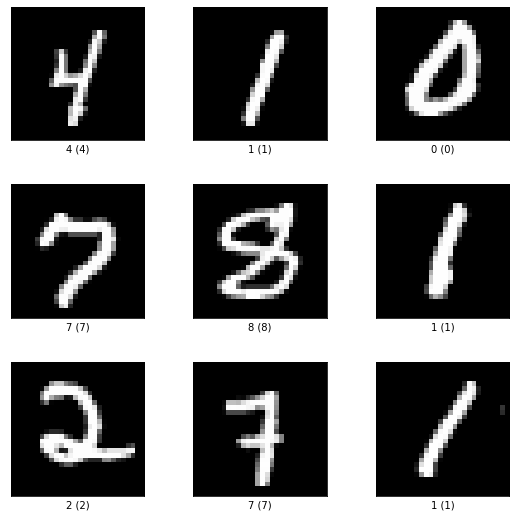

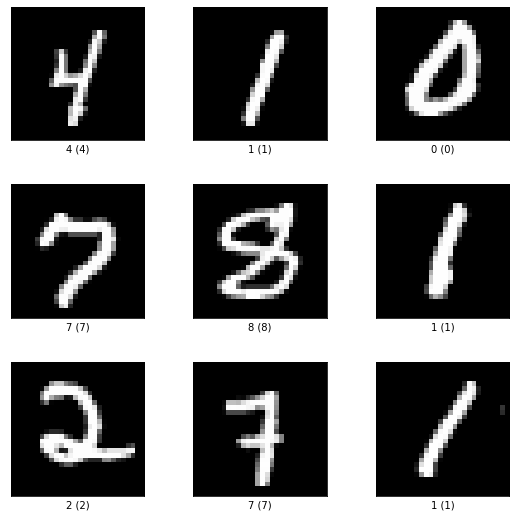

# 2.2 Setting up the data pipeline





In [6]:
#change datatype from uint8 to tf.float values
train_ds = train_ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
test_ds = test_ds.map(lambda img, target: (tf.cast(img, tf.float32), target))


In [7]:
#flatten images through reshape function
#-1 flattens to 1 dimensions and inferst the size
train_ds = train_ds.map(lambda img, target: (tf.reshape(img, (-1,)), target))
test_ds = test_ds.map(lambda img, target: (tf.reshape(img, (-1,)), target))

In [8]:
train_ds = train_ds.map(lambda img, target: ((img/128.)-1., target))
test_ds = test_ds.map(lambda img, target: ((img/128.)-1., target))

In [9]:
train_ds = train_ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
test_ds = test_ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

In [10]:

train_ds = train_ds.batch(32)
test_ds = test_ds.batch(32)



# 2.3 Building a deep neural network with TensorFlow


In [11]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    def __init__(self, nl1=256, nl2=256):
        super(MyModel, self).__init__() 
        self.dense1 = tf.keras.layers.Dense(nl1, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(nl2, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
  
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

# class MyModel(tf.keras.Model): #take a subclass from keras.Model
    
#     def __init__(self):
#         super(MyModel, self).__init__() #initialise the class from which we inherit
#         # self.inp = tf.keras.Input(shape=(784, )) #define the size of the input layer
#         self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
#         self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
#         self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
  
#     @tf.function
#     def call(self, inputs):
#         # x = self.inp(inputs)
#         x = self.dense1(inputs)
#         x = self.dense2(x)
#         x = self.out(x)
#         return x




# 2.4 Training the network



In [12]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  # to back propagate errors, you have to keep track of the gradients of your computation and then apply these gradients to an optimiser
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) #weights are updated here
  return loss


def test(model, test_data, loss_function): #Can the model generalise to test data?
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1) #this gives a yes or no
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy #get average loss and accuracy


# do we need to get the accuracy of the training for visualisation? could be added here.
def training_loop(model, epochs, training_ds, test_ds, loss_function, optimizer):

  # variables necessary for visualization
  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  #testing once before we begin
  test_loss, test_accuracy = test(model, test_ds, loss_function)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  for epoch in range(epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_ds:
        train_loss = train_step(model, input, target, loss_function, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  return train_losses, test_losses, test_accuracies

In [13]:
#run training loop
model = MyModel()
epochs = 10 #n times through training and test data
learning_rate = 0.1
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                     epochs=epochs, 
                                                     training_ds=train_ds,
                                                     test_ds=test_ds, 
                                                     loss_function=loss_function, 
                                                     optimizer=optimizer)

Epoch: 0 starting with accuracy 0.09464856230031948
Epoch: 1 starting with accuracy 0.9547723642172524
Epoch: 2 starting with accuracy 0.9663538338658147
Epoch: 3 starting with accuracy 0.9702476038338658
Epoch: 4 starting with accuracy 0.9719448881789138
Epoch: 5 starting with accuracy 0.9679512779552716
Epoch: 6 starting with accuracy 0.9744408945686901
Epoch: 7 starting with accuracy 0.9718450479233227
Epoch: 8 starting with accuracy 0.9757388178913738
Epoch: 9 starting with accuracy 0.9740415335463258


# 2.5 Visualization

In [14]:
#incorporate accuracy of the training into plot, if needed
def visualization(train_losses, test_losses, test_accuracies):

  """ Visualizes accuracy and loss for training and test data using the mean of each epoch.Loss is displayed in a regular line , accuracy in a dotted
  line. Training data is displayed in blue, test data in red .

  Parameters
  ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    test_losses : numpy . ndarray
    test losses
    test_accuracies : numpy . ndarray
    test accuracies
  """

  plt . figure ()
  line1 , = plt. plot ( train_losses , "b-")
  line2 , = plt. plot ( test_losses , "r-")
  #line3 , = plt. plot ( train_accuracies , "b:")
  line3 , = plt. plot ( test_accuracies , "r:")
  plt . xlabel (" Training steps ")
  plt . ylabel (" Loss / Accuracy ")
  plt . legend ((line1, line2, line3), (" training loss ", " test loss ", " train accuracy ", " test accuracy "))
  plt . show ()

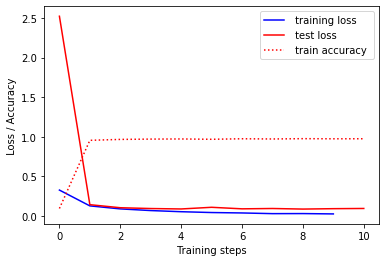

In [15]:
import matplotlib.pyplot as plt

visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)

# 3. Adjusting hyperparameters

The main hyperparameters to adjust are:
- learning rate
- batch size
- number and size of layers
- optimizer


> Taking two cases of learning reate (5 epochs are sufficient)


---


*   0.05 very small learning rate:
    
    with slightly lower learning rate the gradient update would be slower but results are similar.
*   0.5 very high learning rate:

    It has adverse effects on the result, as it loses the minima point and is not able to recover. gradients are updated ferociously and are not recoverable.





--------- Running with Learning rate :  0.05 ---------
Epoch: 0 starting with accuracy 0.10692891373801917
Epoch: 1 starting with accuracy 0.9501797124600639
Epoch: 2 starting with accuracy 0.963158945686901
Epoch: 3 starting with accuracy 0.9704472843450479
Epoch: 4 starting with accuracy 0.9732428115015974



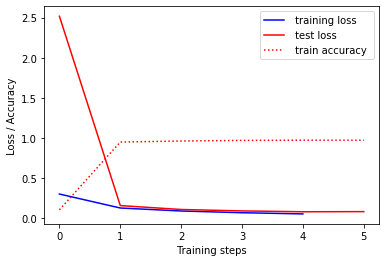

In [ ]:
#run training loop
model = MyModel()
epochs = 5 #n times through training and test data
learning_rate = 0.05
loss_function = tf.keras.losses.CategoricalCrossentropy()

print("--------- Running with Learning rate : ", learning_rate, "---------")
optimizer = tf.keras.optimizers.SGD(learning_rate)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                    epochs=epochs, 
                                                    training_ds=train_ds,
                                                    test_ds=test_ds, 
                                                    loss_function=loss_function, 
                                                    optimizer=optimizer)

print()
visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)

--------- Running with Learning rate :  0.5 ---------
Epoch: 0 starting with accuracy 0.09774361022364217
Epoch: 1 starting with accuracy 0.09804313099041534
Epoch: 2 starting with accuracy 0.10083865814696485
Epoch: 3 starting with accuracy 0.11351837060702875
Epoch: 4 starting with accuracy 0.11351837060702875



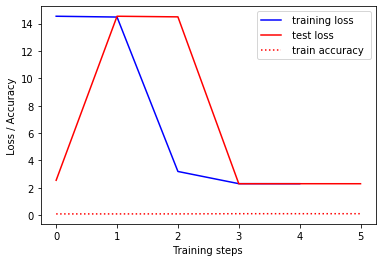

In [ ]:
#run training loop
model = MyModel()
epochs = 5 #n times through training and test data
learning_rate = 0.5
loss_function = tf.keras.losses.CategoricalCrossentropy()

print("--------- Running with Learning rate : ", learning_rate, "---------")
optimizer = tf.keras.optimizers.SGD(learning_rate)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                    epochs=epochs, 
                                                    training_ds=train_ds,
                                                    test_ds=test_ds, 
                                                    loss_function=loss_function, 
                                                    optimizer=optimizer)

print()
visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)


> Learning rate =0.1 with momentum = 0.1



with each batch the weights are updated by the gradients calculated, momentum addition accelerates gradient descent in the relevant direction and dampens oscillations


Epoch: 0 starting with accuracy 0.056309904153354635
Epoch: 1 starting with accuracy 0.9517771565495208
Epoch: 2 starting with accuracy 0.9644568690095847
Epoch: 3 starting with accuracy 0.9646565495207667
Epoch: 4 starting with accuracy 0.9636581469648562



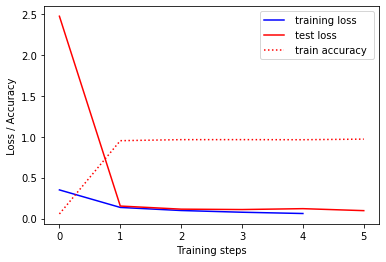

In [ ]:
model = MyModel()
epochs = 5 #n times through training and test data
learning_rate = 0.1
loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.1)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                    epochs=epochs, 
                                                    training_ds=train_ds,
                                                    test_ds=test_ds, 
                                                    loss_function=loss_function, 
                                                    optimizer=optimizer)

print()
visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)


> Using Adam optimizer 

Adam is an adaptive deep neural network training optimizer that has been widely used across a variety of applications. However, on image classification problems, its generalization performance is significantly worse than stochastic gradient descent (SGD).



Epoch: 0 starting with accuracy 0.12320287539936102
Epoch: 1 starting with accuracy 0.09824281150159744
Epoch: 2 starting with accuracy 0.09824281150159744
Epoch: 3 starting with accuracy 0.09824281150159744
Epoch: 4 starting with accuracy 0.09824281150159744



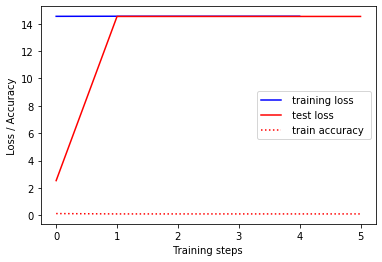

In [ ]:
model = MyModel()
epochs = 5 #n times through training and test data
learning_rate = 0.01
loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer =tf.keras.optimizers.Adam(learning_rate)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                    epochs=epochs, 
                                                    training_ds=train_ds,
                                                    test_ds=test_ds, 
                                                    loss_function=loss_function, 
                                                    optimizer=optimizer)

print()
visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)

Changing the size and number of layers

1.   128, 128
    
    less time is taken for the iterations as less number of weights have to be updated. but accuracy is slightly less

2.   256, 128

    slightly less time is taken and almost similar results to original one



Epoch: 0 starting with accuracy 0.08306709265175719
Epoch: 1 starting with accuracy 0.9459864217252396
Epoch: 2 starting with accuracy 0.9617611821086262
Epoch: 3 starting with accuracy 0.9644568690095847
Epoch: 4 starting with accuracy 0.9653554313099042



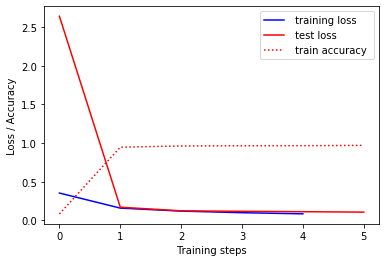

In [ ]:
model = MyModel(128,128)
epochs = 5 #n times through training and test data
learning_rate = 0.1
loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.1)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                    epochs=epochs, 
                                                    training_ds=train_ds,
                                                    test_ds=test_ds, 
                                                    loss_function=loss_function, 
                                                    optimizer=optimizer)

print()
visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)

Epoch: 0 starting with accuracy 0.11611421725239617
Epoch: 1 starting with accuracy 0.9568690095846646
Epoch: 2 starting with accuracy 0.9624600638977636
Epoch: 3 starting with accuracy 0.9674520766773163
Epoch: 4 starting with accuracy 0.9709464856230032



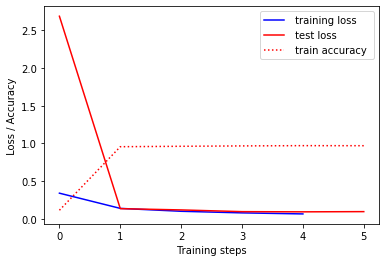

In [ ]:
model = MyModel(256,128)
epochs = 5 #n times through training and test data
learning_rate = 0.1
loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.1)

train_loss, test_loss, test_accuracy = training_loop(model=model, 
                                                    epochs=epochs, 
                                                    training_ds=train_ds,
                                                    test_ds=test_ds, 
                                                    loss_function=loss_function, 
                                                    optimizer=optimizer)
print()
visualization(train_losses=train_loss, test_losses=test_loss, test_accuracies=test_accuracy)